In [3]:
import os
import json 
from glob import glob
import torchio as tio
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
input_scan_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset025_MICCAI/imagesTr/"
output_scan_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/imagesTr/"

input_label_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset025_MICCAI/labelsTr/"
output_label_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/labelsTr/"

os.makedirs(output_scan_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

In [4]:
# My transformer
from torchio.data.sampler import label


gen_transformer = tio.Compose(
    [
       tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 99.5)),
        tio.ZNormalization(),
        tio.Resample((2.0, 2.0, 2.0)), #Changes the voxel spacing. Smaller values give higher resolution
        tio.CropOrPad((128, 128, 64), mask_name="mask"), #Changes the voxel count and image size. 
        #mask_name should correspond to the name of the seg mask variable name passed to the tio.Subject. 
        #mask_name ensures the crop/pad centres the tumors
        tio.ToCanonical(),       
    ]
)

train_augmentations = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), p=0.7),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=15, translation=5, p=0.5),
    tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5, p=0.3),
    tio.RandomBiasField(p=0.2),
    tio.RandomNoise(p=0.2),
])

train_transformer = tio.Compose([gen_transformer, train_augmentations])

In [5]:
case_ids = ( 
    sorted([os.path.basename(f).replace('_0000.nii.gz', '')
    for f in glob(os.path.join(input_scan_dir,"**",'*_0000.nii.gz'), recursive=True)])
    )  

In [6]:
mods_per_case = 5

for case in case_ids:
    subject = tio.Subject(
        t1 = tio.ScalarImage(f'{input_scan_dir}/{case}_0000.nii.gz'),
        t2 = tio.ScalarImage(f'{input_scan_dir}/{case}_0001.nii.gz'),
        t1ce = tio.ScalarImage(f'{input_scan_dir}/{case}_0002.nii.gz'),
        flair = tio.ScalarImage(f'{input_scan_dir}/{case}_0003.nii.gz'),
        mask = tio.LabelMap(f'{input_label_dir}/{case}.nii.gz')
    )

    #Original cases
    for idx, modality in enumerate(["t1", "t2", "t1ce", "flair"]):
        final_orig_scan = f"{output_scan_dir}/{case}0_000{idx}.nii.gz"
        subject[modality].save(final_orig_scan)

    final_orig_label = f'{output_label_dir}/{case}0.nii.gz'
    subject.mask.save(final_orig_label)


    # Augmented cases
    for i in range(mods_per_case):
        augmented_data = train_transformer(subject)
        
        for idx, modality in enumerate(["t1", "t2", "t1ce", "flair"]):
            final_scan = f"{output_scan_dir}/{case}{i+1}_000{idx}.nii.gz"
            augmented_data[modality].save(final_scan)

        final_label = f'{output_label_dir}/{case}{i+1}.nii.gz'
        augmented_data.mask.save(final_label)


In [11]:
# Data verification
labs_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/labelsTr"
lab_cases = len(os.listdir(labs_dir))
print(lab_cases)
img_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/imagesTr"
img_case = len(os.listdir(img_dir))
print(f'Total files: {img_case}')
print(f'Unique files: {img_case/4}')

360
Total files: 1440
Unique files: 360.0


In [4]:
# Data verification new environment 
labs_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/labelsTr"
lab_cases = len(os.listdir(labs_dir))
print(lab_cases)
img_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/imagesTr"
img_case = len(os.listdir(img_dir))
print(f'Total files: {img_case}')
print(f'Unique files: {img_case/4}')

360
Total files: 1440
Unique files: 360.0


In [14]:
# Create dataset.json
modality_mapping = {"t1": 0, "t2": 1, "t1ce": 2, "flair": 3}

labs_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/labelsTr"
num_cases = len(os.listdir(labs_dir))


dataset_json = {
    "channel_names": {str(v): k for k, v in modality_mapping.items()},
    "labels": {
        "background": 0,
        "NCR": 1,
        "ED": 2,
        "ET": 3
    },
    "numTraining": num_cases,
    "file_ending": ".nii.gz"
}

directory = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/"

with open(f"{directory}/dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

#### Data Visualization
* Visualising 1 original and 1 augmented flair images with the corresponding mask

In [4]:
case2_flair_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/imagesTr/BraTS-SSA-00002-0000_0003.nii.gz"
mod_case2_flair_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/imagesTr/BraTS-SSA-00002-0005_0003.nii.gz"
case2_seg_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/labelsTr/BraTS-SSA-00002-0000.nii.gz"
mod_case2_seg_dir = "/teamspace/studios/this_studio/nnUNet_raw/Dataset005_MICCAIAug/labelsTr/BraTS-SSA-00002-0005.nii.gz"

orig_flair_sample = nib.load(case2_flair_dir).get_fdata()
mod_flair_sample = nib.load(mod_case2_flair_dir).get_fdata()
orig_seg_sample = nib.load(case2_seg_dir).get_fdata()
mod_seg_sample = nib.load(mod_case2_seg_dir).get_fdata()

print("Original image & mask shape:",orig_flair_sample.shape, orig_seg_sample.shape)
print("Modified Image & mask shape:", mod_flair_sample.shape, mod_seg_sample.shape)

Original image & mask shape: (240, 240, 155) (240, 240, 155)
Modified Image & mask shape: (128, 128, 64) (128, 128, 64)


(-0.5, 127.5, 127.5, -0.5)

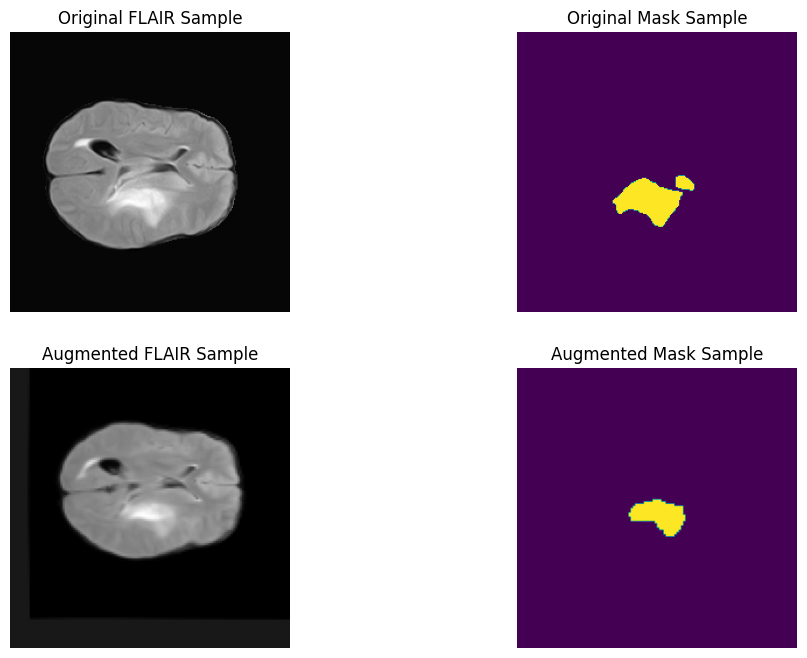

In [8]:
orig_slice = orig_flair_sample.shape[2] // 2
mod_slice = mod_flair_sample.shape[2] // 2

plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.imshow(orig_flair_sample[:, :, orig_slice], cmap='gray')
plt.title('Original FLAIR Sample')
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(orig_seg_sample[:, :, orig_slice])
plt.title('Original Mask Sample')
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(mod_flair_sample[:, :, mod_slice], cmap='gray')
plt.title('Augmented FLAIR Sample')
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(mod_seg_sample[:, :, mod_slice])
plt.title('Augmented Mask Sample')
plt.axis("off")